# Dissolving clusters

This notebook lays out a mechanism for dissoving clusters based on volunteer classifications.  It begins by taking MNIST as an example.  The analysis begins from the point where we have run Unsupervised Deep Embedding Clustering on the data.  The next task is to gather volunteer classifications for subjects and to use these classifications to determine each clusters' class and to use the labels to improve the purity of the clustering.  At this point we only know which subjects are assigned to which clusters, we don not know how pure the clusters are.

In [1]:
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.initializers import Initializer
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K
from keras.models import load_model

sys.path.insert(0,'../DEC-keras')
from DEC import DEC, ClusteringLayer, cluster_acc

sys.path.insert(0,'../experiments/dissolving')
from dissolving_utils import get_cluster_centres, get_cluster_to_label_mapping
from dissolving_utils import pca_plot, FrameDumpCallback, percent_fpr
from dissolving_utils import MappingLayer, MapInitializer

sys.path.insert(0,'../experiments/dissolving/siamese')
from siamese_utils import get_pairs_auto, get_pairs_auto_with_noise, train_siamese, train_siamese_online

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum):
  dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
  ae_weights = ae_weights
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=ae_weights,
                       x=x, loss='kld')
  dec.load_weights(dec_weights)
  dec.model.summary()
  return dec

### Constants

In [3]:
# colours for plotting
lcolours = ['#D6FF79', '#B0FF92', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#CAA8F5', '#D9F0FF', '#46351D']

In [4]:
# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 2e4
update_interval = 140
n_clusters = 10 # number of clusters to use

## MNIST example

In [5]:
from datasets import load_mnist
# load mnist data set
x, y = load_mnist()

MNIST samples (70000, 784)


The data is split into training, validation and test sets.  The intial training acts as the data that would be queried for volunteer classifications.  This training set is chosen uniformly at random from the entire data set.  This has the effect of targeting the most densely populated regions of the embedded feature space i.e. close to the cluster centres.  The labelled training set can grow over time - we select a small batch of data, ask volunteers for classifications, update the model and identify a new batch of data for which to gather volunteer classifications.

The validation set will act as the gold standard data set for measuring performance.  This data set must either be provided up front by the research team or built from an initial run of the citizen science project.

The test set will be held out and not used in this analysis, it is for publications purposes.  It might be worthwhile enouraging projects to build a test set lablled by themselves that is held out until the project ends.

In [6]:
# split the data into training, validation and test sets
m = x.shape[0]
m = m - 20000
sample_frac = 0.01 # begin by querying only 1% of the available training data
split = int(sample_frac*m)
print(split)

# the training set acts as the sample of data for which we query volunteer classifications.
# Here the data is sampled uniformly at random from the entire data set, this targets the most densely 
# populated regions of feature space.
x_train = x[:split]
y_train = y[:split] # volunteer classifications are simulated by using the labels 
                    # - this assumes volunteers are 100% correct

x_valid = x[50000:60000]
y_valid = y[50000:60000]

x_test  = x[60000:]
y_test  = y[60000:]

500


In [7]:
n_classes = len(np.unique(y_train)) # number of classes

In [8]:
# load pretrained DEC model
ae_weights  = '../DEC-keras/results/mnist/ae_weights.h5'
dec_weights = '../DEC-keras/results/mnist/%d/DEC_model_final.h5'%n_clusters
dec = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [9]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)

In [10]:
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
print('cluster n_assigned cluster_majority_class cluster_purity\n')
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

cluster n_assigned cluster_majority_class cluster_purity

0 39 8 0.974358974359
1 51 0 0.980392156863
2 53 7 0.962264150943
3 55 3 0.909090909091
4 34 4 0.5
5 63 1 0.984126984127
6 53 2 0.943396226415
7 37 5 0.972972972973
8 71 4 0.492957746479
9 44 6 1.0
[8, 0, 7, 3, 4, 1, 2, 5, 4, 6]


Note that cluster 4 and 9 above are highly confused.  We want to remedy this by using the volunteer classifications to improve the embedding of subjects assigned to these clusters while not disrupting the embedding for the clusters that are performing well.

In [11]:
FoMs = [cluster_acc(y_valid, dec.predict_clusters(x_valid))] # make a measurement of the clustering accuracy
n_labelled = [0]

In [12]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)

In [13]:
# determine current unlabelled samples
y_plot = np.array(y[:m],dtype='int')
y_plot[split:] = -1

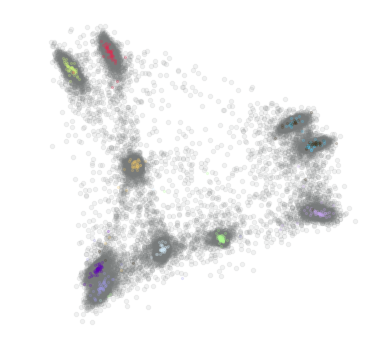

In [14]:
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x[:m], cluster_centres, y=y_plot, labels=labels, lcolours=lcolours)

## Siamese Networks

The DEC algorithm does not have a mechanism for learning from labelled data.  The most natural method for updating the network on labelled data is to use a mapping layer that turns the model into a supervised learner (see experiments 2b and 2c [here](https://nbviewer.jupyter.org/github/dwright04/machine_augmented_classification/blob/master/notebooks/Unsupervised_Deep_Embedding_Clustering_for_Zooniverse.ipynb#Experiment-2b---design-the-mapping-layer)).  However, this approach only seems to work if the initial clustering already produces clusters that are for the most part very pure, this is likely when the data is highly structured e.g. MNIST or Muon Hunter and less likely when the data contains more subtle structure e.g. Supernova Hunters and camera trap projects.

The proposed solution is to turn the DEC model into a siamese network.  Instead of directly learning from the labels a siamese network learns to differentiate between pairs of inputs.  We generate pairs of similar and dissimilar inputs and tell the network which are which.  In our case the pairs will consist of a cluster centre and an embedded image.  We create a training set of pairs based on volunteer classifications we want images assigned to correct clusters to have high similarity and those assigned to incorrect cluster ot have low similarity.  We tell the network which clusters centres to assign labelled images to and which to ensure the image is far from.

We build the siamese network by using the DEC model as the main body of the network which embeds the data.

In [15]:
# get siamese training pairs -  there are 10 times more pairs than lablled images because there are 10 clusters.
im, cc, ls, cluster_to_label_mapping = get_pairs_auto(dec, x_train, y_train, cluster_centres, \
                                                      cluster_to_label_mapping, majority_class_fractions, n_clusters)

False


Train the siamese network on these pairs for 5 epochs (informed by most learning taking place in first few epochs and danger of overfitting the training set).

In [16]:
model, base_network = train_siamese(dec, cluster_centres, im, cc, ls, epochs=5, split_frac=1.0)

Train on 5000 samples, validate on 0 samples
Epoch 1/5
5000/5000 [==============================] - 2s - loss: 0.4455      

In [17]:
# measure performance
FoMs.append(cluster_acc(y_valid, dec.predict_clusters(x_valid)))
n_labelled.append(x_train.shape[0])

Repeat the process of gathering volunteer feedback and updating the siamese network for 5 new batches of subjects which are 1% the size of the data set available for training.  These are again selected uniformly at random.  Update the model for 1 epoch per new batch.

In [18]:
#y_pred = dec.predict_clusters(x[:m])
for j in range(1,5):
  #selection = np.where(y_pred[j*split:(j+1)*split] == np.argmin(majority_class_fractions))
  #x_train = np.concatenate((x_train, x[:m][j*split:(j+1)*split][selection]))
  x_tmp = x[:m][j*split:(j+1)*split]#[selection]
  y_tmp = y[:m][j*split:(j+1)*split]#[selection]
  #x_train = x[:m][j*split:(j+1)*split][selection]
  #y_train = y[:m][j*split:(j+1)*split][selection]
  im_tmp, cc_tmp, ls_tmp, cluster_to_label_mapping = \
    get_pairs_auto(dec, x_tmp, y_tmp, cluster_centres, \
                   cluster_to_label_mapping, majority_class_fractions, n_clusters)
  #im = np.concatenate((im, im_tmp))
  #cc = np.concatenate((cc, cc_tmp))
  #ls = np.concatenate((ls, ls_tmp))
  model, base_network = train_siamese(dec, cluster_centres, im_tmp, cc_tmp, ls_tmp, epochs=1, split_frac=1.0)
  #model, base_network = train_siamese(dec, cluster_centres, im, cc, ls, epochs=1, split_frac=1.0)
  print(cluster_acc(y_valid, dec.predict_clusters(x_valid)))
  FoMs.append(cluster_acc(y_valid, dec.predict_clusters(x_valid))) # make a measurement after each batch
  n_labelled.append((j+1)*split)

True
Train on 5000 samples, validate on 0 samples
Epoch 1/1
5000/5000 [==============================] - 2s - loss: 5.2758       

In [19]:
print(FoMs)

[0.87690000000000001, 0.9012, 0.9244, 0.92830000000000001, 0.92620000000000002, 0.92920000000000003]


Plot a learning curve of the process.  We have only labelled 5% of all the available data (2500 subjects) but achieve 93% accuracy on the validation set which contains 10000 subjects.  The siamese network approach appears to improve performance.  Compare with cell 77 [here](https://nbviewer.jupyter.org/github/dwright04/machine_augmented_classification/blob/master/notebooks/Unsupervised_Deep_Embedding_Clustering_for_Zooniverse.ipynb#Experiment-2b---design-the-mapping-layer), where using the mapping layer and solely supervised approach we achieve ~96% accuracy with 1000 labelled subjects.

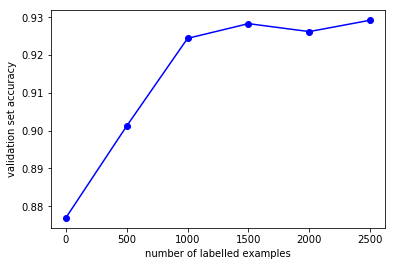

In [20]:
plt.plot(n_labelled, FoMs, 'b-')
plt.plot(n_labelled, FoMs, 'bo')
plt.ylabel('validation set accuracy')
plt.xlabel('number of labelled examples')
plt.show()

## SNHunters

### Define metrics

Unlike the MNIST data set the Supernova Hunters data (like most real-world data sets) is highly skewed to 1 class.  This means accuracy should not be used to measure performance. In the past the 1% FPR has been used as the metric for the Supernova Hunters data set, but the clustering does not immediately lend itself to this metric.  Instead for this analysis use the F1-score which accounts for skewed classes, the higher the F1-score the better the performance. 

In [21]:
def calc_f1_score(y_true, predicted_clusters):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return f1_score(y_true, np.array(y_pred))

In [22]:
# ignore for now
def calc_percent_fpr(y_true, predicted_clusters, percent):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return percent_fpr(y_true, y_pred, percent)

Load in the labelled training set used to train the current Supernova Hunters classifier.

In [23]:
# load snhunters data set
data = sio.loadmat('../data/3pi_20x20_skew2_signPreserveNorm.mat')
x = np.concatenate((data['X'], data['testX']))
y = np.squeeze(np.concatenate((data['y'], data['testy'])))

As this is a harder task, we query larger batches of data, for MNIST we had batches of 500 (1% of all the available data) here we use 2593 subjects per batch (50% of the data set used to train the current classifier. Note: more data is available from the Supernova Hunters project with lables provided by volunteers, see section on online volunteer supervised learning).

In [24]:
# split the data into training, validation and test sets similar to MNIST
m = data['X'].shape[0]
m = m - int(.25*m)
sample_frac = 0.5
split = int(sample_frac*m)
print(m,split)
x_train = data['X'][:split]
y_train = np.squeeze(data['y'])[:split]
x_valid = data['X'][split:]
y_valid = np.squeeze(data['y'])[split:]
x_test  = data['testX']
y_test  = np.squeeze(data['testy'])

5187 2593


In [25]:
n_clusters = 10 # use 10 clusters again
n_classes = len(np.unique(y_train))

In [26]:
# load the pretrained DEC model for Supernova Hunters
ae_weights  = '../DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '../DEC-keras/results/snh/%d/DEC_model_final.h5'%n_clusters
dec = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110.0
Trainable params: 1,473,110.0
Non-trainable params: 0.0
____________________________________________________________

In [27]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)

In [28]:
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

0 52 0 1.0
1 133 0 0.669172932331
2 252 0 0.714285714286
3 410 0 0.690243902439
4 146 0 0.630136986301
5 625 0 0.5872
6 534 0 0.780898876404
7 240 0 0.604166666667
8 2 0 1.0
9 199 0 0.603015075377
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The cluster assignments and purity are much more varied than for MNIST.

In [29]:
# make a performance measurement
FoMs = [calc_f1_score(y_valid, dec.predict_clusters(x_valid))]
#FoMs = [calc_mean_cluster_purity(y_valid, dec.predict_clusters(x_valid), n_classes, n_clusters)]
#print(calc_percent_fpr(y_valid, dec.predict_clusters(x_valid)))
#percent = 0.1
#FoMs = [calc_percent_fpr(y_valid, dec.predict_clusters(x_valid), percent)]
n_labelled = [0]
print(FoMs)

[0.0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)

In [31]:
# determine current unlabelled samples
y_plot = np.array(y[:m],dtype='int')
y_plot[split:] = -1

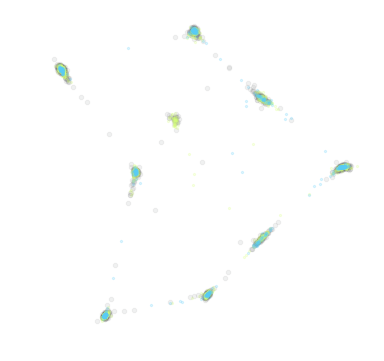

In [32]:
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x[:m], cluster_centres, y=y_plot, labels=labels, lcolours=[lcolours[0], lcolours[4]])

In [33]:
# get siamese training pairs
im, cc, ls, cluster_to_label_mapping = get_pairs_auto(dec, x_train, y_train, cluster_centres, \
                                                      cluster_to_label_mapping, majority_class_fractions, n_clusters)

False


In [34]:
model, base_network = train_siamese(dec, cluster_centres, im, cc, ls, epochs=5, split_frac=1.0)

Train on 25930 samples, validate on 0 samples
Epoch 1/5
25930/25930 [==============================] - 9s - loss: 0.3422       

In [35]:
FoMs.append(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
#print(calc_percent_fpr(y_valid, dec.predict_clusters(x_valid)))
#FoMs.append(calc_percent_fpr(y_valid, dec.predict_clusters(x_valid), percent))
#FoMs.append(calc_mean_cluster_purity(y_valid, dec.predict_clusters(x_valid), n_classes, n_clusters))
n_labelled.append(x_train.shape[0])
print(FoMs)

[0.0, 0.23446327683615817]


In [36]:
y_pred = dec.predict_clusters(x_train)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

0 1381 0 0.718320057929
1 0 0 nan
2 791 0 0.60809102402
3 0 0 nan
4 0 0 nan
5 421 0 0.650831353919
6 0 0 nan
7 0 0 nan
8 0 0 nan
9 0 0 nan
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Repeat the process of gathering volunteer feedback and updating the siamese network for 1 new batch of subjects which is 50% the size of the data set available for training.  These are again selected uniformly at random.  Update the model for 1 epoch per new batch.

In [37]:
#y_pred = dec.predict_clusters(x[:m])
for j in range(1,2):
  #selection = np.where(y_pred[j*split:(j+1)*split] == np.argmin(majority_class_fractions))
  #x_train = np.concatenate((x_train, x[:m][j*split:(j+1)*split][selection]))
  #y_train = np.concatenate((y_train, y[:m][j*split:(j+1)*split][selection]))
  x_tmp = x[:m][j*split:(j+1)*split]#[selection]
  y_tmp = y[:m][j*split:(j+1)*split]#[selection]
  #x_train = x[:m][j*split:(j+1)*split][selection]
  #y_train = y[:m][j*split:(j+1)*split][selection]
  im_tmp, cc_tmp, ls_tmp, cluster_to_label_mapping = \
    get_pairs_auto(dec, x_tmp, y_tmp, cluster_centres, \
                   cluster_to_label_mapping, majority_class_fractions, n_clusters)
  #im = np.concatenate((im, im_tmp))
  #cc = np.concatenate((cc, cc_tmp))
  #ls = np.concatenate((ls, ls_tmp))
  #model, base_network = train_siamese(dec, cluster_centres, im, cc, ls, epochs=5, split_frac=1.0)
  model, base_network = train_siamese(dec, cluster_centres, im_tmp, cc_tmp, ls_tmp, epochs=5, split_frac=1.0)
  #print(cluster_acc(y_valid, dec.predict_clusters(x_valid)))
  print(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
  #print(calc_percent_fpr(y_valid, dec.predict_clusters(x_valid)))
  FoMs.append(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
  #FoMs.append(calc_percent_fpr(y_valid, dec.predict_clusters(x_valid), percent))
  #FoMs.append(calc_mean_cluster_purity(y_valid, dec.predict_clusters(x_valid), n_classes, n_clusters))
  n_labelled.append((j+1)*split)
  print(FoMs)

False
Train on 25930 samples, validate on 0 samples
Epoch 1/5
25930/25930 [==============================] - 9s - loss: 3.2763        

In [38]:
print(FoMs)

[0.0, 0.23446327683615817, 0.37867360208062423]


After gathering labels for 5187 subjects the clustering F1-score has improved from 0.00 to ~0.49.

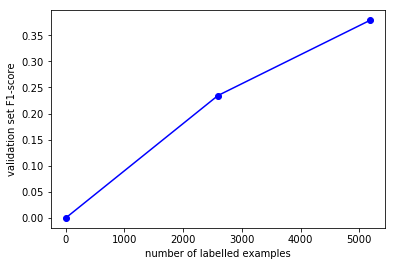

In [39]:
plt.plot(n_labelled, FoMs, 'b-')
plt.plot(n_labelled, FoMs, 'bo')
plt.ylabel('validation set F1-score')
plt.xlabel('number of labelled examples')
plt.show()

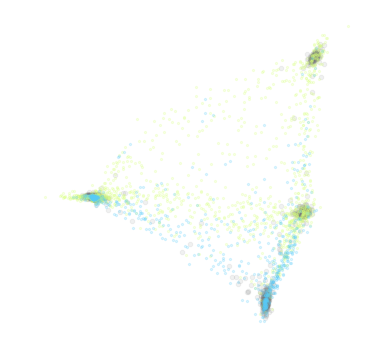

In [40]:
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x[:m], cluster_centres, y=y_plot, labels=labels, lcolours=[lcolours[0], lcolours[4]])

In [41]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)

In [42]:
# inspect the clustering of the training set
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

0 1356 0 0.698377581121
1 332 1 0.795180722892
2 611 0 0.751227495908
3 0 0 nan
4 0 0 nan
5 238 0 0.949579831933
6 0 0 nan
7 0 0 nan
8 3 1 0.666666666667
9 53 0 0.867924528302
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [43]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_valid)

In [44]:
# inspect the clustering of the validation set
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_valid, y_pred, n_classes, n_clusters)

0 2384 0 0.694630872483
1 687 1 0.922852983988
2 821 0 0.90012180268
3 0 0 nan
4 0 0 nan
5 389 0 0.971722365039
6 0 0 nan
7 0 0 nan
8 2 1 1.0
9 40 0 0.9
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The purity of the clusters now appear much better than the initial unsupervised clustering.  Next test the theory that when the clusters are relatively pure we can apply the supervised learning approach.

Take the current realisation of the dec embedding and attach a mapping layer.

In [45]:
a = Input(shape=(400,)) # input layer
q = dec.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model = Model(inputs=a, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Now train this model for 5 epochs (number of epochs justified as before) on the 5187 subjects that we have gathered labels for so far.

In [46]:
model.fit(x[:(j+1)*split], np_utils.to_categorical(y[:(j+1)*split], 2), epochs=5, batch_size=256)

Epoch 1/5
5186/5186 [==============================] - 3s - loss: 0.5058      

In [47]:
print(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
FoMs.append(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
n_labelled.append(n_labelled[-1])

0.897862232779


This further improves the F1-score without the additional cost of gathering more labels and shows that the supervised learning approach can be applied when the clustering performance reaches a certain level of performance.  What that level of performance is is unclear and is likely to be data set specific to a certain extent.  A futher test would be to try applying the supervised approach immediately after the first round of gathering labels.

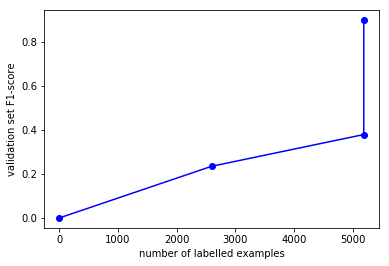

In [48]:
plt.plot(n_labelled, FoMs, 'b-')
plt.plot(n_labelled, FoMs, 'bo')
plt.ylabel('validation set F1-score')
plt.xlabel('number of labelled examples')
plt.show()

## Ablation tests

### when should supervised learning begin


In [ ]:
ae_weights  = '../DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '../DEC-keras/results/snh/%d/DEC_model_final.h5'%n_clusters
dec_ablation = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

In [ ]:
x_ablation = data['X'][:split]
y_ablation = np.squeeze(data['y'])[:split]

In [ ]:
y_pred = dec_ablation.predict_clusters(x_train)

cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

In [ ]:
# get siamese training pairs
im, cc, ls, cluster_to_label_mapping = get_pairs_auto(dec_ablation, x_ablation, y_ablation, cluster_centres, \
                                                      cluster_to_label_mapping, majority_class_fractions, n_clusters)

In [ ]:
model, base_network = train_siamese(dec_ablation, cluster_centres, im, cc, ls, epochs=5, split_frac=1.0)

In [ ]:
y_pred = dec_ablation.predict_clusters(x_ablation)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_ablation, y_pred, n_classes, n_clusters)

In [ ]:
a = Input(shape=(400,)) # input layer
q = dec_ablation.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model_ablation = Model(inputs=a, outputs=pred)
model_ablation.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model_ablation.fit(x_ablation, np_utils.to_categorical(y_ablation, 2), epochs=5, batch_size=256)

In [ ]:
print(calc_f1_score(y_valid, dec_ablation.predict_clusters(x_valid)))

So we get better performance than doing another round of training the siamese network alone, but we get another round of updating the siamese network plus supervised training performs better.  It is unclear whether this is truly a reuslt of the siamese training or just a result of the additional labelled training data.

### number of epochs

Before we continue and begin using actual volunteer classifications from the Supernova Hunters project which trains the model for more epochs and adds additional data to the training we should test the effect of simply traing the model for more epochs on the current lablelled training set.  This allows us to disentangle the contribution of the additional epochs and the additional data to any performance gains.

In [ ]:
ae_weights  = '../DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '../DEC-keras/results/snh/%d/DEC_model_final.h5'%n_clusters
dec_ablation = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

In [ ]:
for i in range(len(dec.model.layers)):
  dec_ablation.model.layers[i].set_weights(dec.model.layers[i].get_weights())

In [ ]:
a = Input(shape=(400,)) # input layer
q = dec_ablation.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model_ablation = Model(inputs=a, outputs=pred)
model_ablation.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model_ablation.fit(x[:(j+1)*split], np_utils.to_categorical(y[:(j+1)*split], 2), epochs=252, batch_size=256)

In [ ]:
print(calc_f1_score(y_valid, dec_ablation.predict_clusters(x_valid)))

## Online volunteer supervised learning

In [50]:
a = Input(shape=(400,)) # input layer
q = dec.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model = Model(inputs=a, outputs=pred)
#sgd = SGD(lr=1e-3)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#dec_2 = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)
#for i in range(len(dec.model.layers)):
#  dec_2.model.layers[i].set_weights(dec.model.layers[i].get_weights())

In [ ]:
x_l = x[:(j+1)*split]
y_l = y[:(j+1)*split]
for i in range(1,10):
  data_snh = sio.loadmat('../data/3pi_20x20_supernova_hunters_batch_%d_signPreserveNorm.mat'%(i))
  x_u = np.nan_to_num(np.reshape(data_snh['X'], (data_snh['X'].shape[0], 400), order='C'))
  y_u = np.squeeze(data_snh['y'])
  #try:
  #  x_u = np.concatenate((x_u, x_snh))
  #  y_u = np.concatenate((y_u, y_snh))
  #except NameError:
  #  x_u = x_snh
  #  y_u = y_snh
  soft_assignments = dec.model.predict(x_u)
  m = soft_assignments.shape[0]
  query_limit = 128
  indices = np.concatenate((np.argsort(np.max(soft_assignments, axis=1))[:query_limit], \
                            np.argsort(np.max(soft_assignments, axis=1))[m-query_limit:]))
  x_l = np.concatenate((x_l, x_u[indices]))
  y_l = np.concatenate((y_l, y_u[indices]))
  #x_l = x_u[indices]
  #y_l = y_u[indices]
  #np.delete(x_u, indices)
  #np.delete(y_u, indices)
  model.fit(x_l, np_utils.to_categorical(y_l, 2), epochs=1, batch_size=256)
  print(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
  FoMs.append(calc_f1_score(y_valid, dec.predict_clusters(x_valid)))
  n_labelled.append(x_l.shape[0])

In [ ]:
plt.plot(n_labelled, FoMs, 'b-')
plt.plot(n_labelled, FoMs, 'bo')
plt.ylabel('validation set F1-score')
plt.xlabel('number of labelled examples')
plt.show()